## 1. Load Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
plt.style.use("seaborn-white")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer; lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, pos_tag

import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import Word

from sklearn import metrics,svm,naive_bayes,decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD

from PIL import Image
from collections import Counter
import datetime
import re

## 2. Import Data & Quick View

In [2]:
df = pd.read_csv('clause classification dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12920 entries, 0 to 12919
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   clause   12920 non-null  object
 1   passage  12920 non-null  object
dtypes: object(2)
memory usage: 202.0+ KB


In [3]:
df.head()

,clause,passage
0,amendment,This Agreement may only be amended by a writte...
1,amendment,This Agreement may be amended or modified only...
2,amendment,This Agreement may be amended by mutual consen...
3,amendment,This Agreement may not be amended except by an...
4,amendment,This Agreement may be amended by the parties h...


In [4]:
df.clause.value_counts()

amendment          1000
arbitration        1000
assignment         1000
governing-law      1000
termination        1000
taxes              1000
indemnification    1000
miscellaneous      1000
confidentiality    1000
force-majeure      1000
effective-date     1000
disclosure         1000
insurance           920
Name: clause, dtype: int64

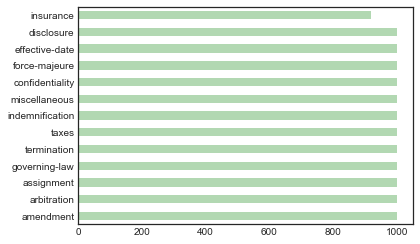

In [5]:
df.clause.value_counts().plot.barh(color = "green", alpha = 0.3)
plt.show()

In [6]:
df["length"] = df.passage.apply(nltk.word_tokenize).apply(len)
df.head()

,clause,passage,length
0,amendment,This Agreement may only be amended by a writte...,18
1,amendment,This Agreement may be amended or modified only...,26
2,amendment,This Agreement may be amended by mutual consen...,112
3,amendment,This Agreement may not be amended except by an...,22
4,amendment,This Agreement may be amended by the parties h...,89


In [7]:
df.groupby('clause')['length'].agg([np.min,np.max]).head()

,amin,amax
clause,,
amendment,2,482
arbitration,2,491
assignment,6,493
confidentiality,4,482
disclosure,2,500


In [8]:
clause_length = df.groupby('clause').agg({'length':'mean'})
clause_length.reset_index(inplace=True)
clause_length.sort_values(by="length",inplace=True, ascending=False)
clause_length['length'] = np.round(clause_length['length'],2)
x = clause_length["clause"].values
y = clause_length["length"].values
fig = plt.figure(figsize=(10,8),dpi=1000)
plt.bar(x,y, label="Length By Clause", color="turquoise", alpha=0.8)
for a,b,i in zip(x,y,range(len(x))): # zip 函数
    plt.text(a,b+0.01,"%.2f"%y[i],ha='center',fontsize=12, rotation=0)
plt.ylabel('Count', fontsize=15)
plt.title('Average Passage Length By Clause', fontweight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.show()

In [9]:
cleaned_df = df[["clause","passage"]]
cleaned_df = cleaned_df[pd.notnull(cleaned_df['passage'])]
cleaned_df['passage'] = cleaned_df['passage'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
cleaned_df['passage'] = cleaned_df['passage'].str.replace('[^\w\s]', '')
cleaned_df['passage'] = cleaned_df['passage'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
cleaned_df['passage'] = cleaned_df['passage'].apply(lambda x: ' '.join(x
        for x in x.split() if x not in stopwords.words('english')))
df = cleaned_df
df.head()

,clause,passage
0,amendment,agreement may amended written instrument execu...
1,amendment,agreement may amended modified written instrum...
2,amendment,agreement may amended mutual consent party pro...
3,amendment,agreement may amended except instrument writin...
4,amendment,agreement may amended party hereto without con...


## 3. Word Cloud

In [10]:
def word_frq(dataframe, clause_name):
    
    # 1. get corresponding clause
    df_clause = dataframe[df.clause == clause_name]
    
    # 2. clean passages: stopwords, letters, lemmatization
    df_clause.passage = df_clause.passage.str.lower().str.strip()
    passage_list = df_clause.passage.tolist()
    passage_list = " ".join(passage_list)
    passage_list = re.sub('[^A-Za-z0-9]+',' ', passage_list)
    
    nltk_tokens = nltk.word_tokenize(passage_list)
    nltk_tokens = [x for x in nltk_tokens if x not in stopwords.words('english') and len(x)>1]
    
    lem_tokens = [lemmatizer.lemmatize(word) for word in nltk_tokens]
    lem_passage = " ".join(lem_tokens)
    
    # 3. plot wordcloud
    wordcloud = WordCloud(mask = np.array(Image.open("cloud.png")), max_words = 100,
                          background_color = "white",
                          stopwords = stopwords.words('english'), min_font_size = 5).generate(lem_passage)
    plt.figure(figsize = (8,8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()
    
    # 4. show top 20 useful words
    count_word = Counter(lem_tokens)
    count_word = sorted(count_word.items(), key = lambda x:x[1], reverse = True)
    print("* Top 20 meaningful words in",clause_name,"*\n")
    print(pd.Series(dict(count_word[:20])))

In [11]:
clause = df.clause.unique()
clause

array(['amendment', 'arbitration', 'assignment', 'governing-law',
       'insurance', 'termination', 'taxes', 'indemnification',
       'miscellaneous', 'confidentiality', 'force-majeure',
       'effective-date', 'disclosure'], dtype=object)

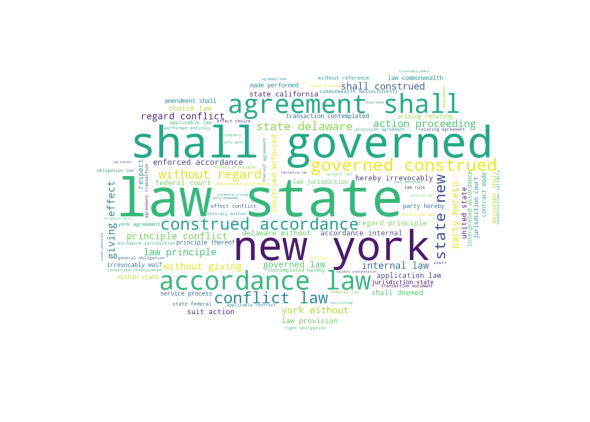

* Top 20 meaningful words in governing-law *

law             2148
state           1449
shall           1341
agreement       1275
governed         902
accordance       836
construed        806
new              663
york             645
party            589
without          569
conflict         551
court            422
principle        405
jurisdiction     399
proceeding       334
action           323
delaware         300
provision        298
regard           297
dtype: int64


In [12]:
word_frq(df, clause[3])

## 4. Topic Modeling

In [13]:
def topic_modeling(dataframe, clause_name):
    
    df = dataframe
    df = df[df.clause == clause_name]
    
    df['passage'] = df['passage'].apply(lambda x:
                                        x.replace('\n', '')).apply(lambda x: 
                                        re.sub(r"\d+", "", x)).apply(lambda x: 
                                        re.sub('\W+',' ', x)).str.lower().str.strip()

    df['passage_preprocessed'] = df['passage'].apply(lambda x:
                                            ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    
    text_encoder = Pipeline([
    ('tfidf_vec', TfidfVectorizer(stop_words="english", min_df = 5, max_df = 0.9)),
    ('normalize', Normalizer()),
    ('lda', LDA(n_components = 5))], verbose=True)

    passage_vec = text_encoder.fit_transform(df['passage_preprocessed'])
    
    def print_topics(model, vectorizer, n_top_words):
        words = vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % (topic_idx+1))
            print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print("\n")
    print("Topics found via LDA in %s:"% clause_name)
    print_topics(text_encoder['lda'], text_encoder['tfidf_vec'], 10)

In [14]:
topic_modeling(df, clause[10])

[Pipeline] ......... (step 1 of 3) Processing tfidf_vec, total=   0.0s
[Pipeline] ......... (step 2 of 3) Processing normalize, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   1.0s


Topics found via LDA in force-majeure:

Topic #1:
party shall act failure delay force majeure event agreement performance

Topic #2:
conditioning light create utmost air fluctuation exceed standard nuclear release

Topic #3:
currency exchange security nationalization expropriation subadviser manager sovereign custodian observe

Topic #4:
noncompliance master concerted penalty worker general enforcement according clause occurred

Topic #5:
trustee lessee agent bank lessor indenture wire prescribed accepted banking


## 5. Confusion Matrix Visualization

In [15]:
def cm_analysis(y_true, y_pred, labels, algorithm, figsize=(10,8)):

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = algorithm + ' Actual'
    cm.columns.name = algorithm + ' Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap = 'rocket_r')

## 6. Logistic Regression & TF-IDF Clause Classification

In [16]:
def clause_classification(dataframe, passage_input):
    
    # some prep
    df = dataframe
    
    train_x, test_x, train_y, test_y = train_test_split(df.passage, df.clause, stratify=df.clause, test_size=0.2, random_state=42)
    
    if type(passage_input) == str:
        passage_input = pd.Series(passage_input)
    
    original_passage = passage_input
    
    start_time = datetime.datetime.now()
    
    original_test_y = test_y 
    
    # feature engineering 
    encoder = LabelEncoder()    
    train_y = encoder.fit_transform(train_y)
    test_y = encoder.fit_transform(test_y)
    
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
    tfidf_vect_ngram.fit(df.passage)

    xtrain_tfidf_ngram = tfidf_vect_ngram.transform(train_x)
    xtest_tfidf_ngram = tfidf_vect_ngram.transform(test_x)
    
    passage_input = tfidf_vect_ngram.transform(passage_input)
    
    # train LR     
    logi = LogisticRegression()
    logi.fit(xtrain_tfidf_ngram, train_y)
    
    # test LR
    logi_test_predictions = logi.predict(xtest_tfidf_ngram)
    logi_test_predictions_reverse = encoder.inverse_transform(logi_test_predictions)
    logi_predictions = encoder.inverse_transform(logi.predict(passage_input))
    
    # track time
    end_time = datetime.datetime.now()
    lg_cal_time = (end_time-start_time).seconds
    
    # show result
    print("Time:{} sec".format(lg_cal_time))
    print(classification_report(list(original_test_y),list(logi_test_predictions_reverse), labels=list(df.clause.unique()),
                         target_names=list(df.clause.unique()), digits=3))
    cm_analysis(list(original_test_y),list(logi_test_predictions_reverse),list(df.clause.unique()), "Logistics Regression")
    print(' ')
    return(pd.DataFrame({'Predicted_Clause':logi_predictions,'Input_Passage':original_passage}))
    

Time:4 sec
                 precision    recall  f1-score   support

      amendment      0.939     0.920     0.929       200
    arbitration      0.995     0.960     0.977       200
     assignment      0.938     0.980     0.958       200
  governing-law      0.946     0.970     0.958       200
      insurance      0.957     0.967     0.962       184
    termination      0.938     0.900     0.918       200
          taxes      0.956     0.970     0.963       200
indemnification      0.925     0.930     0.928       200
  miscellaneous      0.845     0.820     0.832       200
confidentiality      0.901     0.960     0.930       200
  force-majeure      1.000     0.970     0.985       200
 effective-date      0.966     0.865     0.913       200
     disclosure      0.808     0.885     0.845       200

       accuracy                          0.930      2584
      macro avg      0.932     0.931     0.931      2584
   weighted avg      0.932     0.930     0.930      2584

 


,Predicted_Clause,Input_Passage
990,amendment,agreement may amended andor terminated time mu...
991,amendment,agreement may amended time time chl park monac...
992,amendment,amendment agreement shall materially adversely...
993,amendment,amendment addition agreement shall binding unl...
994,amendment,agreement may amended modified explicitly writ...
995,amendment,agreement may amended except written agreement...
996,amendment,agreement may modified amended except writing ...
997,amendment,approval company shareholder amendment agreeme...
998,amendment,agreement may amended varied agreement writing...
999,amendment,amendment waiver compliance provision conditio...


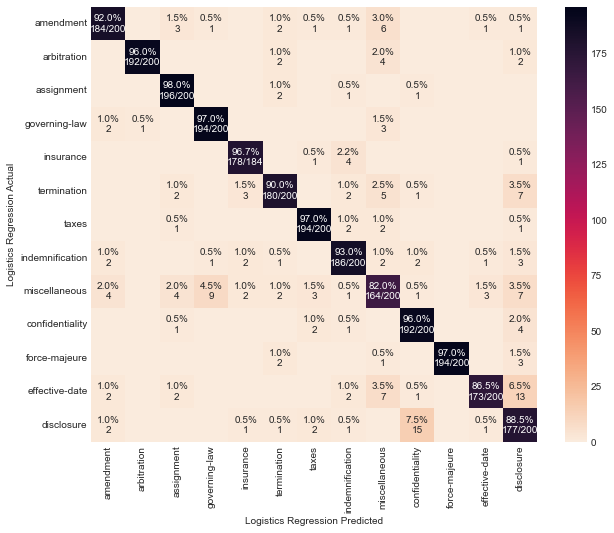

In [17]:
clause_classification(df,df.passage[990:1010])

## 7. Random Forest  & TF-IDF Clause Classification

In [18]:
def random_forest_classification_analysis(dataframe, passage_input):
    # some prep
    df = dataframe
    
    train_x, test_x, train_y, test_y = train_test_split(df.passage, df.clause, stratify=df.clause, test_size=0.2, random_state=42)
    
    if type(passage_input) == str:
        passage_input = pd.Series(passage_input)
    
    original_passage = passage_input
    
    start_time = datetime.datetime.now()
    
    original_test_y = test_y 
    
    # feature engineering 
    encoder = LabelEncoder()    
    train_y = encoder.fit_transform(train_y)
    test_y = encoder.fit_transform(test_y)
    
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
    tfidf_vect_ngram.fit(df.passage)

    xtrain_tfidf_ngram = tfidf_vect_ngram.transform(train_x)
    xtest_tfidf_ngram = tfidf_vect_ngram.transform(test_x)
    
    passage_input = tfidf_vect_ngram.transform(passage_input)
    
    # try bagging
    start_time = datetime.datetime.now()
    
    bagging = ensemble.RandomForestClassifier()
    bagging.fit(xtrain_tfidf_ngram, train_y)
    
    bagging_test_predictions = bagging.predict(xtest_tfidf_ngram)
    bagging_test_predictions_reverse = encoder.inverse_transform(bagging_test_predictions)
    bagging_predictions = encoder.inverse_transform(bagging.predict(passage_input))
    
    end_time = datetime.datetime.now()
    bagging_cal_time = (end_time-start_time).seconds
    
    print("Time: {} sec".format(bagging_cal_time))
    
    # importance&confusion matrix visualization
    importance = bagging.feature_importances_
    importance_index = pd.DataFrame({'index':range(0,len(importance),1),"importance":importance})
    importance_index = importance_index[importance_index.importance > 0.005]
    index_importance_table = pd.DataFrame({"index":importance_index.index,"importance":importance[[importance_index.index]]})

    index_word_table = pd.DataFrame({"index":list(tfidf_vect_ngram.vocabulary_.values()),"words":list(tfidf_vect_ngram.vocabulary_.keys())})
    index_word_table = index_word_table[index_word_table['index'].isin(index_importance_table["index"])]
    
    result = pd.merge(index_word_table,index_importance_table, how = 'inner')
    result.sort_values("importance", inplace=True)
    
    fig = plt.figure(figsize=(10,4))
    plt.barh(result["words"], result["importance"], color = "green", alpha = 0.3)
    plt.title("Importance Visualization")
    plt.show()
     
    cm_analysis(list(original_test_y),list(bagging_test_predictions_reverse),list(df.clause.unique()),'Bagging') 
    
    print(classification_report(list(original_test_y),list(bagging_test_predictions_reverse), labels=list(df.clause.unique()),
                         target_names=list(df.clause.unique()), digits=3))
    
    return(pd.DataFrame({'Predicted_Clause':bagging_predictions,'Input_Passage':original_passage}))

Time: 4 sec


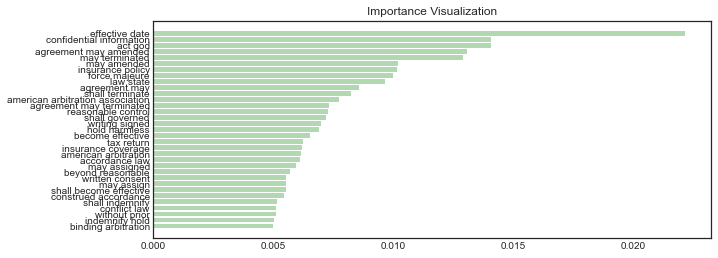

                 precision    recall  f1-score   support

      amendment      0.902     0.920     0.911       200
    arbitration      0.995     0.965     0.980       200
     assignment      0.852     0.980     0.912       200
  governing-law      0.899     0.975     0.935       200
      insurance      0.973     0.967     0.970       184
    termination      0.931     0.875     0.902       200
          taxes      0.950     0.945     0.947       200
indemnification      0.910     0.905     0.907       200
  miscellaneous      0.846     0.715     0.775       200
confidentiality      0.899     0.890     0.894       200
  force-majeure      0.995     0.970     0.982       200
 effective-date      0.805     0.930     0.863       200
     disclosure      0.955     0.845     0.897       200

       accuracy                          0.914      2584
      macro avg      0.916     0.914     0.914      2584
   weighted avg      0.916     0.914     0.913      2584



,Predicted_Clause,Input_Passage
990,amendment,agreement may amended andor terminated time mu...
991,amendment,agreement may amended time time chl park monac...
992,amendment,amendment agreement shall materially adversely...
993,amendment,amendment addition agreement shall binding unl...
994,amendment,agreement may amended modified explicitly writ...
...,...,...
1095,arbitration,dispute controversy arising connection agreeme...
1096,arbitration,controversy claim arising relating agreement b...
1097,arbitration,party hereto shall endeavor settle dispute con...
1098,arbitration,except set forth section 9c disagreement dispu...


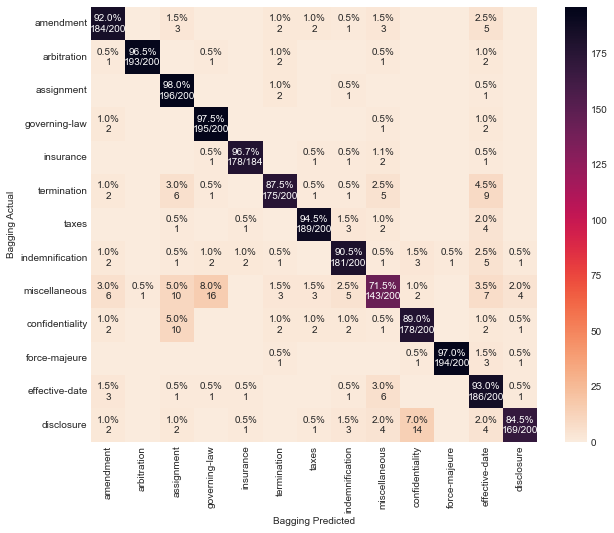

In [19]:
random_forest_classification_analysis(df,df['passage'][990:1100])

## 8.  Error Analysis

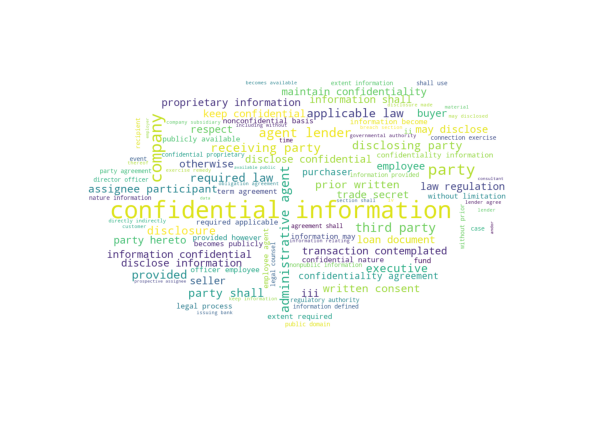

* Top 20 meaningful words in confidentiality *

information        4976
party              2954
confidential       2756
agreement          2120
shall              2029
company            1443
disclosure         1054
agent              1053
required            998
lender              997
may                 937
disclose            877
employee            827
section             814
law                 804
affiliate           801
person              793
provided            771
connection          739
confidentiality     734
dtype: int64


In [20]:
word_frq(df,'confidentiality')

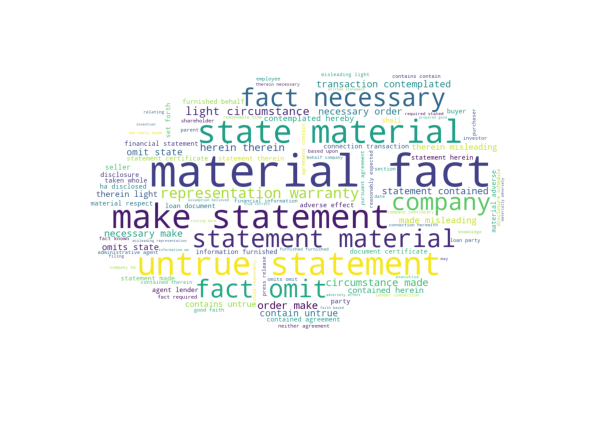

* Top 20 meaningful words in disclosure *

statement         1848
material          1749
fact              1510
agreement         1338
company           1148
information       1112
made               824
make               787
document           710
necessary          703
misleading         672
therein            664
contained          619
state              608
furnished          577
untrue             572
representation     531
ha                 490
herein             481
disclosure         467
dtype: int64


In [21]:
word_frq(df,'disclosure')

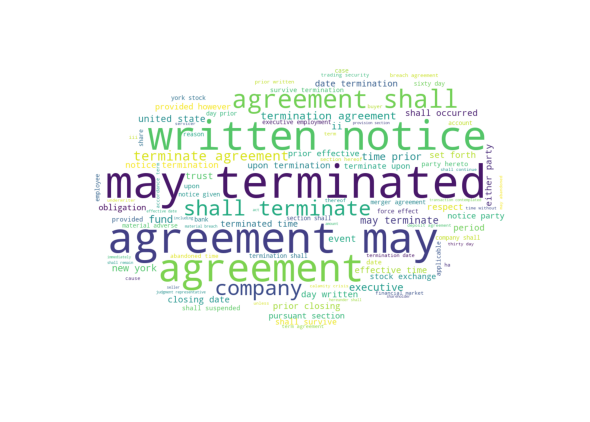

* Top 20 meaningful words in termination *

agreement      2118
shall          1893
termination    1042
may             955
party           832
notice          757
company         710
time            702
terminate       697
date            643
terminated      637
upon            635
section         570
prior           546
security        474
written         447
obligation      428
day             406
event           318
term            315
dtype: int64


In [22]:
word_frq(df,'termination')

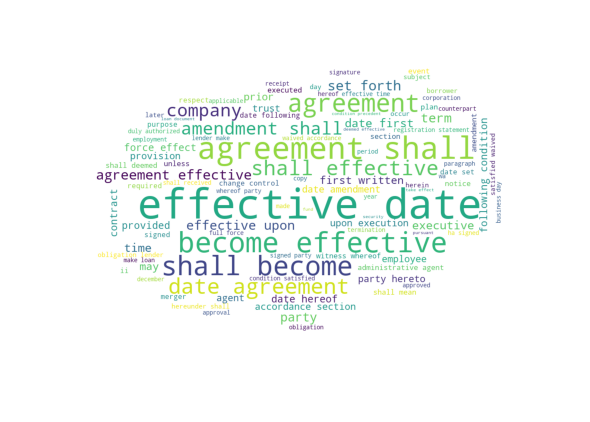

* Top 20 meaningful words in effective-date *

date         1413
effective    1402
agreement    1162
shall        1145
become        360
party         354
amendment     293
upon          243
section       191
day           182
first         182
company       166
term          159
executed      156
ha            153
following     139
time          135
effect        134
condition     134
set           130
dtype: int64


In [23]:
word_frq(df,'effective-date')

# 9. Deep Learning Classification Framework

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [26]:
df['clause'] = df['clause'].replace(df.clause.unique(),[1,2,3,4,5,6,7,8,9,10,11,12,13])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
         df['passage'], df['clause'], stratify=df['clause'],
         test_size=0.2, random_state=42,
         )

In [28]:
X_train.shape, X_test.shape

((10336,), (2584,))

In [29]:
X_train

11492    agreement ha executed day 20 effective 20 wadd...
10566    reason force majeure owner andor lessee unable...
10923    agreement shall become effective company repre...
3041     agreement shall governed construed accordance ...
8244     event provision agreement found invalid unenfo...
                               ...                        
9579     executive acknowledges obligation confidential...
10930    effective date registration statement prospect...
602                      amendment agreement shall writing
5975     federal state local tax return required filed ...
11992    loan party ha disclosed lender agreement instr...
Name: passage, Length: 10336, dtype: object

In [31]:
text_encoder = Pipeline([
    ('tf-idf', TfidfVectorizer(ngram_range=(1, 2), min_df = 5, max_df = 0.9)),
    ('svd', TruncatedSVD(n_components = 300))], verbose=True)

In [32]:
train_vec = text_encoder.fit_transform(X_train)
test_vec = text_encoder.transform(X_test)

[Pipeline] ............ (step 1 of 2) Processing tf-idf, total=   0.9s
[Pipeline] ............... (step 2 of 2) Processing svd, total=   2.8s


In [33]:
train_vec.shape, test_vec.shape

((10336, 300), (2584, 300))

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [36]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, vecs, labels):
        'Initialization'
        self.labels = labels
        self.vecs = vecs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = torch.as_tensor(self.vecs[index, :], dtype=torch.float32)
        y = torch.as_tensor(self.labels[index]-1, dtype=torch.long)
        return X, y

In [37]:
training_data = Dataset(train_vec, y_train.values)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

validation_data = Dataset(test_vec, y_test.values)
val_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

In [45]:
INPUT_DIM = train_vec.shape[1]
HIDDEN_DIM = 256
NUN_CLASS = 13

In [46]:
class ReviewClassify(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, NUN_CLASS)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, text_vec):
        output_layer1 = self.fc1(text_vec)
        layer_1 = F.relu(output_layer1)
        layer_2 = self.fc2(layer_1)
        output = self.output(layer_2)
        return output

In [47]:
classfier = ReviewClassify()
classfier

ReviewClassify(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=13, bias=True)
  (output): LogSoftmax(dim=1)
)

In [48]:
import torch.optim as optim

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classfier.parameters())

In [50]:
from torch.autograd import Variable
import time

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
losses = []
for epoch in range(10):
    start_time = time.time()
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x = Variable(x_batch)
        y = Variable(y_batch)
        output = classfier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()
        losses.append(train_loss)
    train_acc = (output.argmax(1) == y_batch).sum().true_divide(len(y_batch))
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        
    with torch.no_grad():
        losses = []
        val_acc = 0
        for x_batch, y_batch in val_loader:
            # Transfer to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            x = Variable(x_batch)
            y = Variable(y_batch)
            classfier.eval()
            output = classfier(x)
            loss = criterion(output, y)
            val_acc += (output.argmax(1) == y_batch).sum()
            
            losses.append(loss.item())
            
        val_loss = sum(losses) * 32 / test_vec.shape[0] 
        print(val_acc, len(y_batch))
        val_acc = val_acc.true_divide(test_vec.shape[0])
        print(f'\tVal Loss: {val_loss:.4f}(val)\t|\tVal Acc: {val_acc * 100:.1f}%(val)')

Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 0.4152(train)	|	Acc: 93.8%(train)
tensor(2441) 24
	Val Loss: 0.3675(val)	|	Val Acc: 94.5%(val)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.2335(train)	|	Acc: 96.9%(train)
tensor(2459) 24
	Val Loss: 0.1987(val)	|	Val Acc: 95.2%(val)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 0.0523(train)	|	Acc: 100.0%(train)
tensor(2460) 24
	Val Loss: 0.1735(val)	|	Val Acc: 95.2%(val)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.0796(train)	|	Acc: 96.9%(train)
tensor(2464) 24
	Val Loss: 0.1648(val)	|	Val Acc: 95.4%(val)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.0751(train)	|	Acc: 96.9%(train)
tensor(2455) 24
	Val Loss: 0.1635(val)	|	Val Acc: 95.0%(val)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.2011(train)	|	Acc: 90.6%(train)
tensor(2466) 24
	Val Loss: 0.1607(val)	|	Val Acc: 95.4%(val)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.1700(train)	|	Acc: 96.9%(train)
tensor(2465) 24
	Val Loss: 0.1595(val)	|	Val Acc: 95.4%(val

### Activation Function and Learning Rate

In [52]:
classfier = ReviewClassify()

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classfier.parameters(), lr=0.01, momentum=0.9)

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
losses = []
for epoch in range(30):
    start_time = time.time()
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x = Variable(x_batch)
        y = Variable(y_batch)
        output = classfier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()
        losses.append(train_loss)
    train_acc = (output.argmax(1) == y_batch).sum().true_divide(len(y_batch))
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        
    with torch.no_grad():
        losses = []
        val_acc = 0
        for x_batch, y_batch in val_loader:
            # Transfer to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            x = Variable(x_batch)
            y = Variable(y_batch)
            classfier.eval()
            output = classfier(x)
            loss = criterion(output, y)
            val_acc += (output.argmax(1) == y_batch).sum()
            
            losses.append(loss.item())
            
        val_loss = sum(losses) * 32 / test_vec.shape[0] 
        print(val_acc, len(y_batch))
        val_acc = val_acc.true_divide(test_vec.shape[0])
        print(f'\tVal Loss: {val_loss:.4f}(val)\t|\tVal Acc: {val_acc * 100:.1f}%(val)')

Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 0.2153(train)	|	Acc: 96.9%(train)
tensor(2429) 24
	Val Loss: 0.2451(val)	|	Val Acc: 94.0%(val)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.2106(train)	|	Acc: 96.9%(train)
tensor(2425) 24
	Val Loss: 0.2339(val)	|	Val Acc: 93.8%(val)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 0.2305(train)	|	Acc: 96.9%(train)
tensor(2434) 24
	Val Loss: 0.2260(val)	|	Val Acc: 94.2%(val)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.4095(train)	|	Acc: 87.5%(train)
tensor(2437) 24
	Val Loss: 0.2161(val)	|	Val Acc: 94.3%(val)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.1606(train)	|	Acc: 96.9%(train)
tensor(2445) 24
	Val Loss: 0.2084(val)	|	Val Acc: 94.6%(val)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.1526(train)	|	Acc: 93.8%(train)
tensor(2441) 24
	Val Loss: 0.2032(val)	|	Val Acc: 94.5%(val)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.2272(train)	|	Acc: 93.8%(train)
tensor(2447) 24
	Val Loss: 0.2006(val)	|	Val Acc: 94.7%(val)

### Adding the embedding layer to the deep learning model

In [56]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [57]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/hejunchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
from collections import Counter
import numpy as np

In [59]:
X_train

11492    agreement ha executed day 20 effective 20 wadd...
10566    reason force majeure owner andor lessee unable...
10923    agreement shall become effective company repre...
3041     agreement shall governed construed accordance ...
8244     event provision agreement found invalid unenfo...
                               ...                        
9579     executive acknowledges obligation confidential...
10930    effective date registration statement prospect...
602                      amendment agreement shall writing
5975     federal state local tax return required filed ...
11992    loan party ha disclosed lender agreement instr...
Name: passage, Length: 10336, dtype: object

In [60]:
counts = Counter()
for text in X_train.values:
    counts.update(word_tokenize(text))

In [61]:
counts

Counter({'agreement': 17122,
         'ha': 2751,
         'executed': 886,
         'day': 1438,
         '20': 79,
         'effective': 1847,
         'waddell': 2,
         'reed': 4,
         'financial': 892,
         'inc': 249,
         'daniel': 5,
         'p': 25,
         'connealy': 1,
         'senior': 68,
         'vice': 53,
         'president': 107,
         'chief': 66,
         'officer': 1544,
         'reason': 840,
         'force': 1456,
         'majeure': 806,
         'owner': 407,
         'andor': 593,
         'lessee': 320,
         'unable': 193,
         'perform': 601,
         'obligation': 3933,
         'shall': 18496,
         'give': 330,
         'notice': 2193,
         'district': 149,
         'writing': 1441,
         'within': 1054,
         'ten': 156,
         '10': 306,
         'calendar': 93,
         'first': 534,
         'become': 671,
         'aware': 88,
         'occurrence': 334,
         'relied': 20,
         'upon': 2991,
  

In [62]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 12078
num_words after: 7288


In [63]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [64]:
vocab2index

{'': 0,
 'UNK': 1,
 'agreement': 2,
 'ha': 3,
 'executed': 4,
 'day': 5,
 '20': 6,
 'effective': 7,
 'waddell': 8,
 'reed': 9,
 'financial': 10,
 'inc': 11,
 'daniel': 12,
 'p': 13,
 'senior': 14,
 'vice': 15,
 'president': 16,
 'chief': 17,
 'officer': 18,
 'reason': 19,
 'force': 20,
 'majeure': 21,
 'owner': 22,
 'andor': 23,
 'lessee': 24,
 'unable': 25,
 'perform': 26,
 'obligation': 27,
 'shall': 28,
 'give': 29,
 'notice': 30,
 'district': 31,
 'writing': 32,
 'within': 33,
 'ten': 34,
 '10': 35,
 'calendar': 36,
 'first': 37,
 'become': 38,
 'aware': 39,
 'occurrence': 40,
 'relied': 41,
 'upon': 42,
 'extent': 43,
 'period': 44,
 'time': 45,
 'affected': 46,
 'suspended': 47,
 'endeavor': 48,
 'remove': 49,
 'overcome': 50,
 'inability': 51,
 'reasonable': 52,
 'effort': 53,
 'purpose': 54,
 'provision': 55,
 'mean': 56,
 'act': 57,
 'god': 58,
 'landslide': 59,
 'lightning': 60,
 'earthquake': 61,
 'hurricane': 62,
 'storm': 63,
 'flood': 64,
 'natural': 65,
 'strike': 66,
 '

In [65]:
def encode_sentence(text, vocab2index, N=50):
    tokenized = word_tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [66]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [67]:
X_train

,passage
11492,agreement ha executed day 20 effective 20 wadd...
10566,reason force majeure owner andor lessee unable...
10923,agreement shall become effective company repre...
3041,agreement shall governed construed accordance ...
8244,event provision agreement found invalid unenfo...
...,...
9579,executive acknowledges obligation confidential...
10930,effective date registration statement prospect...
602,amendment agreement shall writing
5975,federal state local tax return required filed ...


In [68]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [70]:
X_train['encoded'] = X_train['passage'].progress_apply(lambda x: np.array(encode_sentence(x,vocab2index)))
X_test['encoded'] = X_test['passage'].progress_apply(lambda x: np.array(encode_sentence(x,vocab2index)))

  0%|          | 0/10336 [00:00<?, ?it/s]

  0%|          | 0/2584 [00:00<?, ?it/s]

In [71]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.as_tensor(self.X['encoded'].values[idx][0], dtype=torch.int64)
        y = torch.as_tensor(self.y.values[idx]-1, dtype=torch.long)
        return X, y

In [72]:
training_data = Dataset(X_train, y_train)
validation_data = Dataset(X_test, y_test)

In [73]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

In [74]:
class ReviewClassify(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(16689, 50, padding_idx = 0)
        self.lstm = nn.LSTM(50, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 13)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, text):
        embed = self.embed(text)
        lstm_out, (ht, ct) = self.lstm(embed)
        layer_0 = self.fc1(ht[-1])
        layer_1 = F.relu(layer_0)
        layer_2 = self.fc2(layer_1)
        output = self.output(layer_2)
        return output

In [75]:
import torch.optim as optim

In [76]:
classfier = ReviewClassify()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classfier.parameters())

In [77]:
classfier

ReviewClassify(
  (embed): Embedding(16689, 50, padding_idx=0)
  (lstm): LSTM(50, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=13, bias=True)
  (output): LogSoftmax(dim=1)
)

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
losses = []
for epoch in range(10):
    start_time = time.time()
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x = Variable(x_batch)
        y = Variable(y_batch)
        output = classfier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()
        losses.append(train_loss)
    train_acc = (output.argmax(1) == y_batch).sum().true_divide(len(y_batch))
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        
    with torch.no_grad():
        losses = []
        val_acc = 0
        for x_batch, y_batch in val_loader:
            # Transfer to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            x = Variable(x_batch)
            y = Variable(y_batch)
            classfier.eval()
            output = classfier(x)
            loss = criterion(output, y)
            val_acc += (output.argmax(1) == y_batch).sum()
            
            losses.append(loss.item())
            
        val_loss = sum(losses) * 32 / test_vec.shape[0] 
        print(val_acc, len(y_batch))
        val_acc = val_acc.true_divide(test_vec.shape[0])
        print(f'\tVal Loss: {val_loss:.4f}(val)\t|\tVal Acc: {val_acc * 100:.1f}%(val)')

Epoch: 1  | time in 0 minutes, 7 seconds
	Loss: 1.9379(train)	|	Acc: 34.4%(train)
tensor(909) 24
	Val Loss: 2.0076(val)	|	Val Acc: 35.2%(val)
Epoch: 2  | time in 0 minutes, 7 seconds
	Loss: 1.3003(train)	|	Acc: 53.1%(train)
tensor(1362) 24
	Val Loss: 1.4788(val)	|	Val Acc: 52.7%(val)
Epoch: 3  | time in 0 minutes, 7 seconds
	Loss: 1.5248(train)	|	Acc: 50.0%(train)
tensor(1683) 24
	Val Loss: 1.0810(val)	|	Val Acc: 65.1%(val)
Epoch: 4  | time in 0 minutes, 7 seconds
	Loss: 0.5779(train)	|	Acc: 78.1%(train)
tensor(2028) 24
	Val Loss: 0.7460(val)	|	Val Acc: 78.5%(val)
Epoch: 5  | time in 0 minutes, 7 seconds
	Loss: 0.4385(train)	|	Acc: 78.1%(train)
tensor(2161) 24
	Val Loss: 0.5704(val)	|	Val Acc: 83.6%(val)
Epoch: 6  | time in 0 minutes, 7 seconds
	Loss: 0.4910(train)	|	Acc: 81.2%(train)
tensor(2231) 24
	Val Loss: 0.4992(val)	|	Val Acc: 86.3%(val)
Epoch: 7  | time in 0 minutes, 7 seconds
	Loss: 0.2063(train)	|	Acc: 90.6%(train)
tensor(2288) 24
	Val Loss: 0.4184(val)	|	Val Acc: 88.5%(val)


In [79]:
def load_glove_vectors(glove_file="glove.42B.300d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [80]:
def get_emb_matrix(pretrained, word_counts, emb_size = 300):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [81]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [82]:
len(vocab2index)

7289

In [86]:
class ReviewClassify(nn.Module):
    def __init__(self, glove_weights):
        super().__init__()
        self.embed = nn.Embedding(7290, 300, padding_idx = 0)
        self.embed.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embed.weight.requires_grad = False
        self.lstm = nn.LSTM(300, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 13)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, text):
        embed = self.embed(text)
        lstm_out, (ht, ct) = self.lstm(embed)
        layer_0 = self.fc1(ht[-1])
        layer_1 = F.relu(layer_0)
        layer_2 = self.fc2(layer_1)
        output = self.output(layer_2)
        return output

In [87]:
classfier = ReviewClassify(pretrained_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classfier.parameters())

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
losses = []
for epoch in range(30):
    start_time = time.time()
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x = Variable(x_batch)
        y = Variable(y_batch)
        output = classfier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()
        losses.append(train_loss)
    train_acc = (output.argmax(1) == y_batch).sum().true_divide(len(y_batch))
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        
    with torch.no_grad():
        losses = []
        val_acc = 0
        for x_batch, y_batch in val_loader:
            # Transfer to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            x = Variable(x_batch)
            y = Variable(y_batch)
            classfier.eval()
            output = classfier(x)
            loss = criterion(output, y)
            val_acc += (output.argmax(1) == y_batch).sum()
            
            losses.append(loss.item())
            
        val_loss = sum(losses) * 32 / test_vec.shape[0] 
        print(val_acc, len(y_batch))
        val_acc = val_acc.true_divide(test_vec.shape[0])
        print(f'\tVal Loss: {val_loss:.4f}(val)\t|\tVal Acc: {val_acc * 100:.1f}%(val)')

Epoch: 1  | time in 0 minutes, 9 seconds
	Loss: 0.1417(train)	|	Acc: 93.8%(train)
tensor(2452) 24
	Val Loss: 0.2002(val)	|	Val Acc: 94.9%(val)
Epoch: 2  | time in 0 minutes, 9 seconds
	Loss: 0.1555(train)	|	Acc: 93.8%(train)
tensor(2447) 24
	Val Loss: 0.1887(val)	|	Val Acc: 94.7%(val)
Epoch: 3  | time in 0 minutes, 9 seconds
	Loss: 0.0942(train)	|	Acc: 96.9%(train)
tensor(2451) 24
	Val Loss: 0.2142(val)	|	Val Acc: 94.9%(val)
Epoch: 4  | time in 0 minutes, 9 seconds
	Loss: 0.1310(train)	|	Acc: 96.9%(train)
tensor(2416) 24
	Val Loss: 0.2464(val)	|	Val Acc: 93.5%(val)
Epoch: 5  | time in 0 minutes, 9 seconds
	Loss: 0.1095(train)	|	Acc: 96.9%(train)
tensor(2455) 24
	Val Loss: 0.1892(val)	|	Val Acc: 95.0%(val)
Epoch: 6  | time in 0 minutes, 9 seconds
	Loss: 0.0979(train)	|	Acc: 96.9%(train)
tensor(2443) 24
	Val Loss: 0.2120(val)	|	Val Acc: 94.5%(val)
Epoch: 7  | time in 0 minutes, 9 seconds
	Loss: 0.0057(train)	|	Acc: 100.0%(train)
tensor(2444) 24
	Val Loss: 0.1971(val)	|	Val Acc: 94.6%(val